In [76]:
import numpy as np
from scipy import integrate
from scipy.special import legendre

In [6]:
density_conversion = 37.96e-9  # 1 m_sun/kpc^3 = 37.96e-9 GeV/cm^3
r_GC = 8.33  # distance to Galactic Center, kpc

In [8]:
def to_cartesian(r, th, ph):
    return np.array([r*np.sin(th)*np.cos(ph),
                     r*np.sin(th)*np.sin(ph),
                     r*np.cos(th)])

## Density profiles

In [47]:
def rho_NFW(r, mx=None, sv=None):
    """NFW profile with annihilation plateau cutoff.
    
    Parameters
    ----------
    r : float
        Distance from GC (kpc).
    """
    r_s = 24.42  # kpc
    rho_s = 0.184  # GeV/cm^3
    t_bh = 1e10*365.25*24*60*60  # s
    
    def _rho_NFW(r):  # profile without cutoff
        return rho_s * r_s/r * (1. + r/r_s)**-2
    
    if mx is not None and r_s is not None:
        rho_core = mx / (sv * t_bh)  # annihilation plateau
        
        return min(_rho_NFW(r), rho_core)
    else:
        return _rho_NFW(r)

In [101]:
def rho_bulge(x, y, z, coords="Cartesian"):
    if coords == "Spherical":
        x, y, z = to_cartesian(x, y, z)

    rho0b = density_conversion * 9.6e9
    r0 = 0.5
    r_max = 3.5
    
    # Ellipsoid orientation
    alpha = 25. * np.pi / 180.
    
    # Ellipsoid axis sizes
    xb = r_GC/8. * 0.899
    yb = r_GC/8. * 0.386
    zb = r_GC/8. * 0.25
    
    # Rotate into ellipsoid's coordinate system
    rot_mat = np.array([[np.cos(alpha), -np.sin(alpha), 0.],
                        [np.sin(alpha), np.cos(alpha), 0.],
                        [0., 0., 1.]])
    xp, yp, zp = np.dot(rot_mat, np.array([x, y, z]))
    rp = np.sqrt(xp**2 + yp**2)
    r1 = np.sqrt((xp/xb)**2 + (yp/yb)**2 + (zp/zb)**2)
    
    # Exponential cutoff outside r_max
    cutoff_fact = 1. if rp < r_max else np.exp(-0.5*(rp - r_max)**2/r0)
    
    return cutoff_fact * rho0b * np.exp(-r1)

In [103]:
def rho_disk(x, y, z, coords="Cartesian"):
    if coords == "Spherical":
        x, y, z = to_cartesian(x, y, z)
        
    H = 2.75  # kpc
    h1 = r_GC/8. * 0.27  # kpc
    h2 = r_GC/8. * 0.44  # kpc
    beta = 0.565
    rho0d = density_conversion * 4.93e7
    
    r = np.sqrt(x**2 + y**2)
    eta = max(0.670, 0.114 + r/9.025)
    
    return rho0d/eta * np.exp(-(r-r_GC)/H) *((1. - beta) / np.cosh(z/(eta*h1))**2 + beta * np.exp(-np.abs(z)/(eta*h2)))

In [104]:
def rho_tot(x, y, z, coords="Cartesian"):
    if coords == "Spherical":
        x, y, z = to_cartesian(x, y, z)
        
    return rho_NFW(np.sqrt(x**2+y**2+z**2)) + rho_disk(x, y, z) + rho_bulge(x, y, z)

Plot all the density profiles

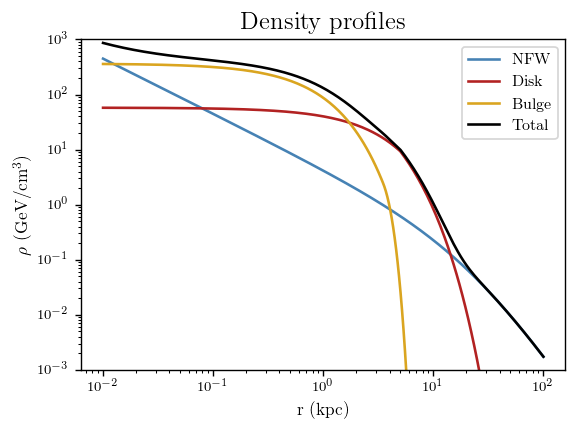

In [105]:
rs = np.logspace(-2, 2, 300)

plt.loglog(rs, [rho_NFW(r) for r in rs], label="NFW")
plt.loglog(rs, [rho_disk(r, 0, 0) for r in rs], label="Disk")
plt.loglog(rs, [rho_bulge(r, 0, 0) for r in rs], label="Bulge")
plt.loglog(rs, [rho_tot(r, 0, 0) for r in rs], "k", label="Total")

plt.ylim(1e-3, 1e3)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\rho$ (GeV/cm$^3$)")
plt.legend()
plt.title("Density profiles")

## Gravitational potential
We need to find $\partial \Phi / \partial r$ so we can substitute it into the Jeans equation

The DM halo contribution is spherically symmetric part and thus easy to compute. Using Gauss' law,

\begin{align}
    \frac{d\Phi}{dr}(r) = \frac{G M_{\text{enclosed}}(r)}{r^2}.
\end{align}

The enclosed mass is

\begin{align}
    M_{\text{enclosed}}(r) &= \int_0^r dr'\ d\theta' d\phi'\ {r'}^2 \sin\theta' \rho(r')\\
    &= 4\pi \int_0^r dr'\ {r'}^2 \rho(r').
\end{align}

In [106]:
def dPhi_dr_NFW(r):
    m_enc = integrate.quad(lambda rp: rp**2 * rho_NFW(rp), 0, r)[0]
    return m_enc / r**2

The disk density profile is azimuthally symmetric, and is invariant under $z \mapsto -z$. It can be treated by performing a multipole expansion:
\begin{align}
    \Phi(r, \theta) &= - G \sum_{l=0}^\infty \left[ \frac{A_l(r)}{r^{l+1}} + B_l(r) r^l \right] P_l(\cos\theta),\\
    A_l(r) &= 2\pi \int_0^r dr'\ \int_0^\pi d\theta'\ \sin\theta' {r'}^{l+2} \rho(r',\theta') P_l(\cos\theta')\\
    B_l(r) &= 2\pi \int_r^\infty dr'\ \int_0^\pi d\theta'\ \sin\theta' \frac{\rho(r',\theta')}{{r'}^{l-1}} P_l(\cos\theta').
\end{align}
The $r$ derivative is
\begin{align}
    \frac{\partial\Phi}{\partial r}(r, \theta) &= - G \sum_{l=0}^\infty \left[ \frac{r A_l'(r) - (l+1) A_l(r)}{r^{l+2}} + \left( r B_l'(r) + l B_l(r) \right) r^{l-1} \right] P_l(\cos\theta),\\
    A_l'(r) &= 2\pi \int_0^\pi d\theta'\ \sin\theta' r^{l+2} \rho(r,\theta') P_l(\cos\theta')\\
    B_l'(r) &= -2\pi \int_0^\pi d\theta'\ \sin\theta' \frac{\rho(r,\theta')}{r^{l-1}} P_l(\cos\theta').
\end{align}

In [118]:
def dPhi_dr_disk_mp_coeff(r, l, r_max=100.):
    def Al_integrand(rp, thp):
        return 2.*np.pi * np.sin(thp) * rp**(l+2) * rho_disk(rp, thp, 0., "Spherical") * legendre(l)(np.cos(thp))
    
    def Bl_integrand(rp, thp):
        return 2.*np.pi * np.sin(thp) / rp**(l-1) * rho_disk(rp, thp, 0., "Spherical") * legendre(l)(np.cos(thp))
    
    # Legendre coefficients
    Al = 2. * integrate.dblquad(Al_integrand,
                                0, r,
                                lambda r: 0, lambda r: np.pi/2.)[0]
    # Don't need this if l=0!
    Bl = 0. if l == 0 else 2. * integrate.dblquad(Bl_integrand,
                                                  0, r,
                                                  lambda r: 0, lambda r: np.pi/2.)[0]
    
    # Radial derivatives of Legendre coefficients
    dAl_dr = 2. * integrate.quad(lambda thp: Al_integrand(r, thp),
                                 0, np.pi/2.)[0]
    dBl_dr = 2. * integrate.quad(lambda thp: -Bl_integrand(r, thp),
                                 0, np.pi/2.)[0]
    
    # Put it all together
    A_terms = -(r * dAl_dr - (l+1) * Al) / r**(l+2)
    B_terms = -(r * dBl_dr + l * Bl) * r**(l-1)
    
    return A_terms + B_terms

In [121]:
print dPhi_dr_disk_mp_coeff(1., 0)
print dPhi_dr_disk_mp_coeff(1., 1)
print dPhi_dr_disk_mp_coeff(1., 2)

17.6800305169
-57.5446351891
-10958.8287826


In [122]:
print dPhi_dr_disk_mp_coeff(1., 3)
print dPhi_dr_disk_mp_coeff(1., 4)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


1968.2948524
2640.51088841


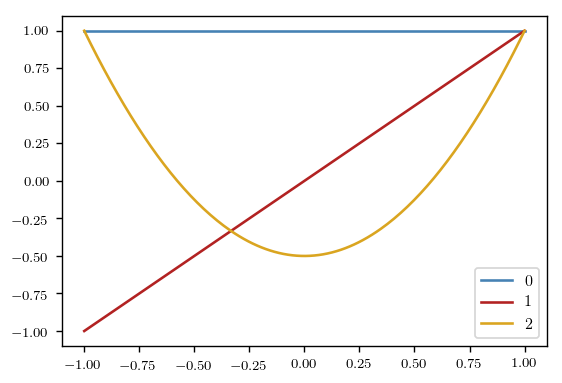

In [80]:
xs = np.linspace(-1, 1, 200)

for d in [0, 1, 2]:
    plt.plot(xs, legendre(d)(xs), label=d)
plt.legend()

In [ ]:
def dPhi_dr_disk(r):
    

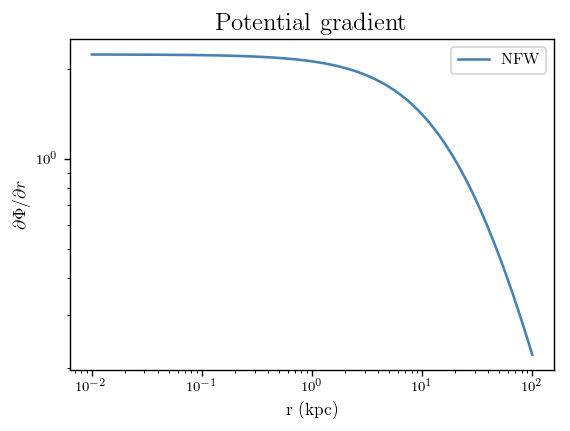

In [75]:
rs = np.logspace(-2, 2, 300)

plt.loglog(rs, [dPhi_dr_NFW(r) for r in rs], label="NFW")

plt.xlabel("r (kpc)")
plt.ylabel(r"$\partial \Phi / \partial r$")
plt.legend()
plt.title("Potential gradient")

In [ ]:
integrate.tplquad(lambda x, y, z: rho_tot(x, y, z) * np.sqrt(x**2+y**2+z**2),
                  0., 10.,
                  lambda x: 0., lambda x: 10.,
                  lambda x, y: 0., lambda x, y: 10.)